<div style="background-color:gray; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Unveiling Cyberbullying through NLP 🕵️‍♂️🛡️</b></h1>
</div>

<div style="background-color:gray; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/iz8Sj3IbgjkAAAAd/people-are-so-mean-online-wario.gif" alt="Animated GIF">
</div>

<div style="background-color:gray; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import requests
from io import BytesIO

import re
import unidecode
import string
import unicodedata

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.regularizers import l1, l2

In [2]:
data = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


<div style="background-color:gray; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>DATA PREPROCESSING AND EDA</b></h2>
</div>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [4]:
data.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [5]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
data['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

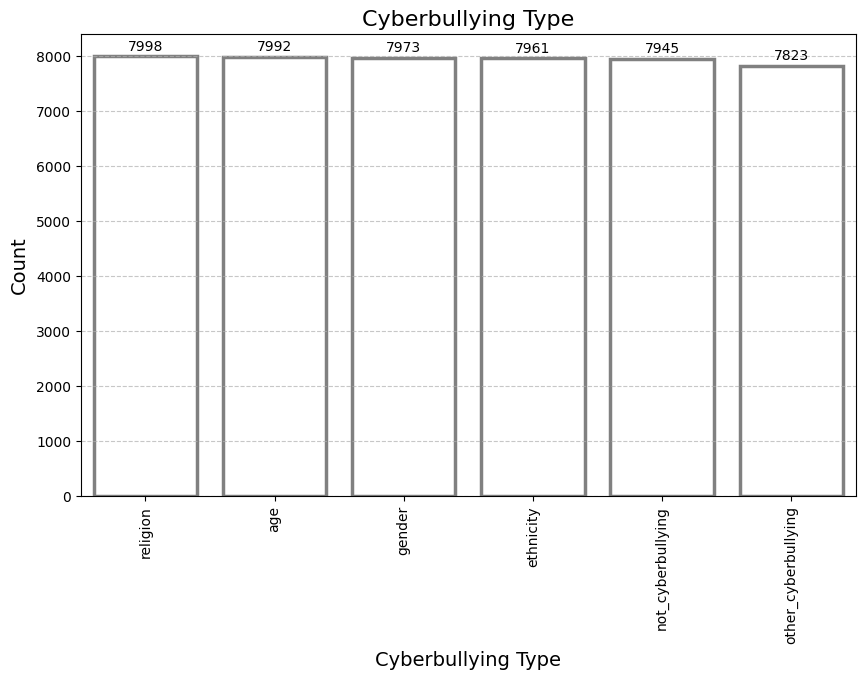

In [7]:
plt.figure(figsize=(10, 6)) 
colors = sns.color_palette("pastel")
ax = sns.barplot(
    x=data['cyberbullying_type'].value_counts().index,
    y=data['cyberbullying_type'].value_counts().values,
    ci="sd",
    capsize=.4,
    errcolor=".5",
    errwidth=2.5,
    linewidth=2.5,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0),
    palette=colors
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Cyberbullying Type", {'fontsize': 16})

for i, v in enumerate(data['cyberbullying_type'].value_counts().values):
    ax.text(i, v + 50, str(v), color='black', ha='center', va='bottom')

ax.set_xlabel("Cyberbullying Type", labelpad=5, fontsize=14)
ax.set_ylabel("Count", labelpad=5, fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

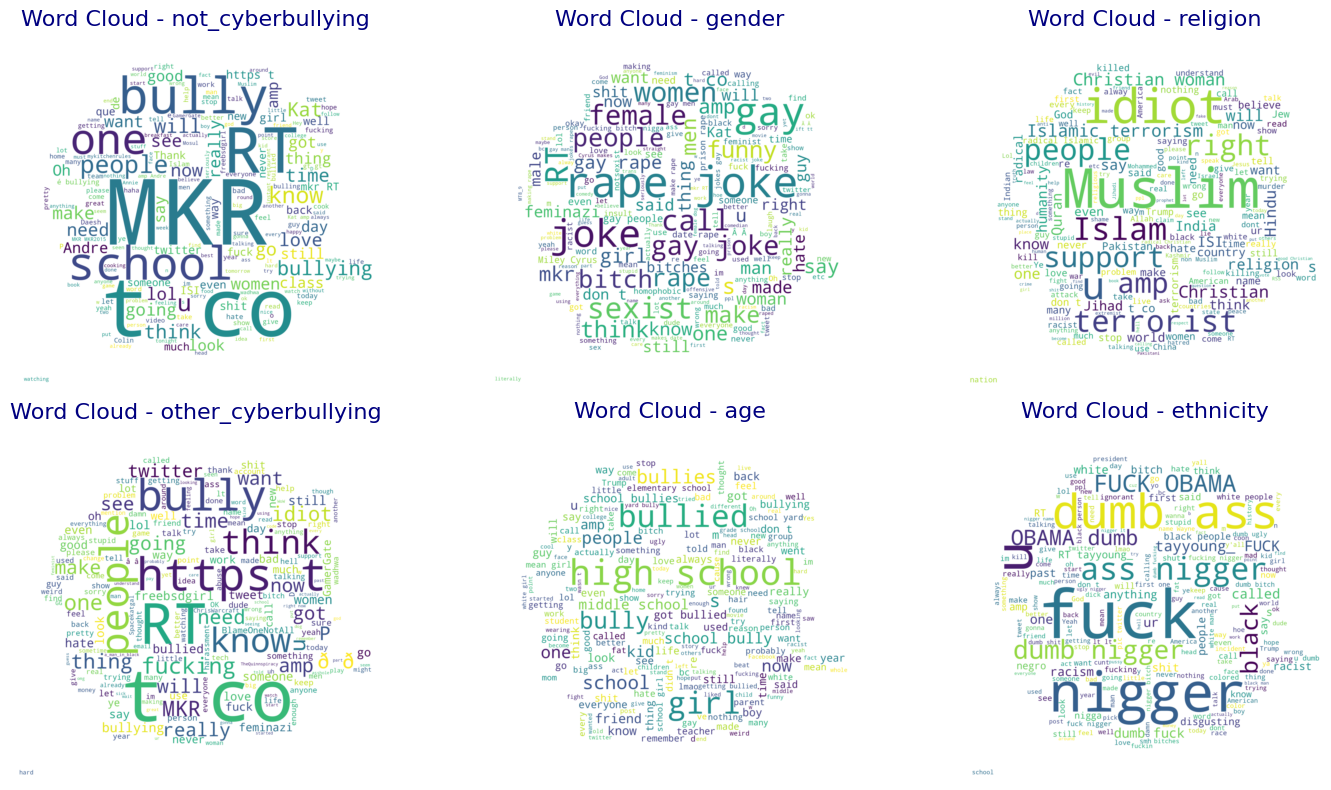

In [8]:
categories = data['cyberbullying_type'].unique()
plt.figure(figsize=(15, 8))
for i, category in enumerate(categories):
    text = data[data['cyberbullying_type'] == category]['tweet_text'].str.cat(sep=' ')
    mask_url = 'https://media.istockphoto.com/id/1301795370/vector/concept-victim-of-bullying-cyber-harassment-cyberstalking-portrait-of-woman-with-frustration.jpg?s=2048x2048&w=is&k=20&c=eAWFdAWd_VYXCvCa_iuP8TV9t3sOuaZqt2NK-ws6M9w='
    mask = np.array(Image.open(BytesIO(requests.get(mask_url).content)))
    wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask).generate(text)
    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {category}', fontsize=16, color='navy')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def preprocess_text(data, col):
    def case_convert(text):
        return text.lower()

    def remove_specials(text):
        return re.sub(r"[^a-zA-Z]", " ", text)

    def remove_shorthands(text):
        words = text.split(" ")
        new_words = [CONTRACTION_MAP[word] if word in CONTRACTION_MAP else word for word in words]
        return " ".join(new_words)

    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        words = text.split(" ")
        filtered_words = [word for word in words if word.strip().lower() not in stop_words]
        return " ".join(filtered_words)

    def remove_links(text):
        remove_https = re.sub(r'http\S+', '', text)
        return re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)

    def remove_accents(text):
        return unidecode.unidecode(text)

    def normalize_spaces(text):
        return re.sub(r"\s+", " ", text)

    data[col] = data[col].apply(case_convert)
    data[col] = data[col].apply(remove_links)
    data[col] = data[col].apply(remove_shorthands)
    data[col] = data[col].apply(remove_accents)
    data[col] = data[col].apply(remove_specials)
    data[col] = data[col].apply(remove_stopwords)
    data[col] = data[col].apply(normalize_spaces)

    return data[col]

data['tweet_text'] = preprocess_text(data, 'tweet_text')
data

,tweet_text,cyberbullying_type
0,words katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau to...,not_cyberbullying
2,xochitlsuckkks classy whore red velvet cupcakes,not_cyberbullying
3,jason gio meh p thanks heads concerned anothe...,not_cyberbullying
4,rudhoeenglish isis account pretending kurdish...,not_cyberbullying
...,...,...
47687,black ppl expected anything depended anything ...,ethnicity
47688,turner withhold disappointment turner called c...,ethnicity
47689,swear god dumb nigger bitch got bleach hair re...,ethnicity
47690,yea fuck rt therealexel youre nigger fucking u...,ethnicity


In [10]:
class_labels = {
    'not_cyberbullying':0,
    'religion':1,
    'age':2,
    'gender':3,
    'ethnicity':4,
    'other_cyberbullying':5
}
data['cyberbullying_type'] = data['cyberbullying_type'].replace(class_labels).astype(int)
data['cyberbullying_type'].value_counts()

cyberbullying_type
1    7998
2    7992
3    7973
4    7961
0    7945
5    7823
Name: count, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'],data['cyberbullying_type'], test_size=0.2, random_state=42)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet_text'])
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences  = tokenizer.texts_to_sequences(X_test)

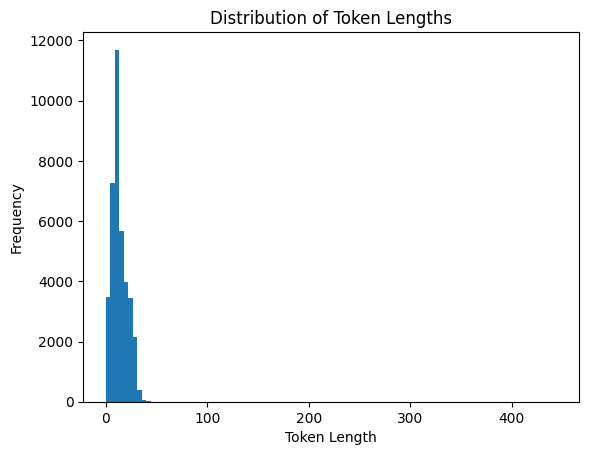

In [13]:
token_lengths = [len(sequence) for sequence in X_train_sequences]
plt.hist(token_lengths, bins=100)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
mean_length   = np.mean(token_lengths)
median_length = np.median(token_lengths)
max_length    = int(mean_length + 2 * np.std(token_lengths))

print(f"Mean Token Length   : {mean_length}")
print(f"Median Token Length : {median_length}")
print(f"Max Token Length    : {max_length}")

Mean Token Length   : 13.509081854637905
Median Token Length : 12.0
Max Token Length    : 29


In [15]:
max_length     = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded  = pad_sequences(X_test_sequences , maxlen=max_length, padding='post')

<div style="background-color:gray; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>MODEL ENGINEERING</b></h2>
</div>

--------------------- Logistic Regression ---------------------
Accuracy: 0.26795261557815286
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.25      0.22      1624
           1       0.32      0.45      0.37      1566
           2       0.30      0.09      0.14      1603
           3       0.26      0.09      0.13      1531
           4       0.22      0.13      0.17      1603
           5       0.29      0.58      0.39      1612

    accuracy                           0.27      9539
   macro avg       0.26      0.27      0.24      9539
weighted avg       0.26      0.27      0.24      9539



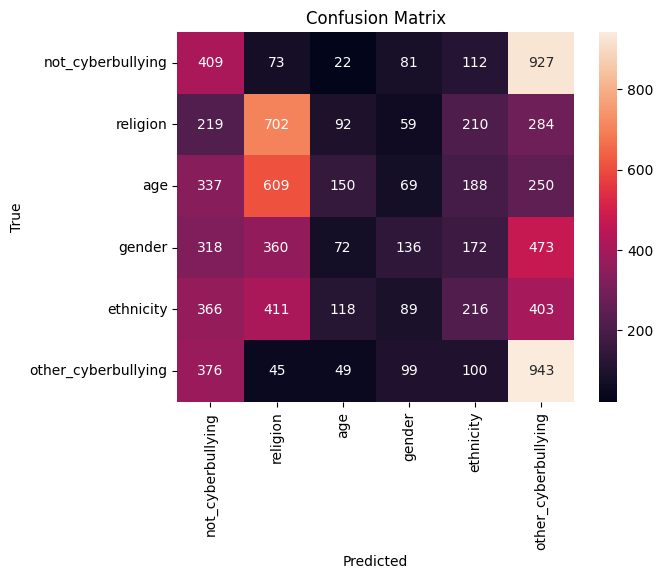



--------------------- Decision Tree ---------------------
Accuracy: 0.6126428346786875
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.52      0.50      1624
           1       0.58      0.55      0.57      1566
           2       0.80      0.80      0.80      1603
           3       0.60      0.62      0.61      1531
           4       0.72      0.71      0.72      1603
           5       0.50      0.47      0.48      1612

    accuracy                           0.61      9539
   macro avg       0.61      0.61      0.61      9539
weighted avg       0.61      0.61      0.61      9539



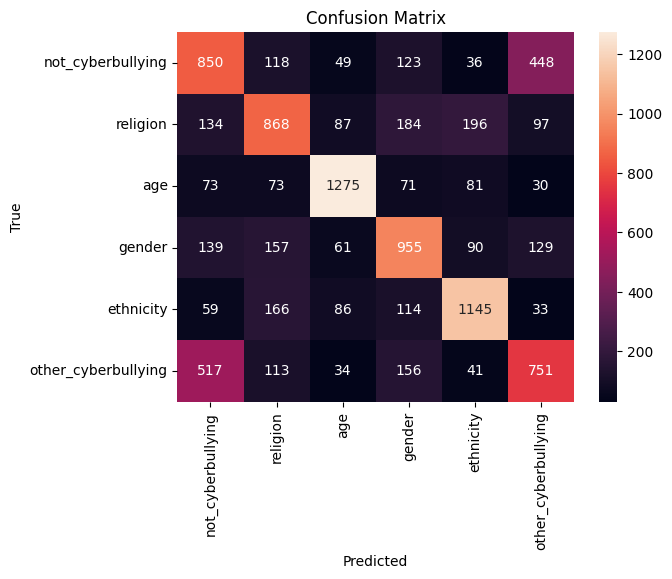



--------------------- Random Forest ---------------------
Accuracy: 0.698291225495335
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.59      0.57      1624
           1       0.66      0.73      0.69      1566
           2       0.87      0.92      0.89      1603
           3       0.72      0.66      0.68      1531
           4       0.86      0.77      0.81      1603
           5       0.56      0.54      0.55      1612

    accuracy                           0.70      9539
   macro avg       0.70      0.70      0.70      9539
weighted avg       0.70      0.70      0.70      9539



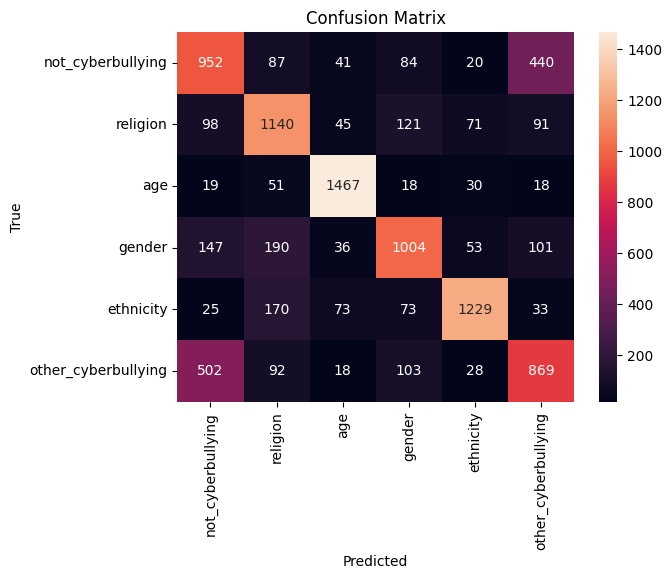



--------------------- SVM ---------------------
Accuracy: 0.446692525421952
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.57      0.49      1624
           1       0.47      0.45      0.46      1566
           2       0.30      0.53      0.39      1603
           3       0.56      0.25      0.35      1531
           4       0.70      0.42      0.53      1603
           5       0.49      0.46      0.47      1612

    accuracy                           0.45      9539
   macro avg       0.49      0.44      0.45      9539
weighted avg       0.49      0.45      0.45      9539



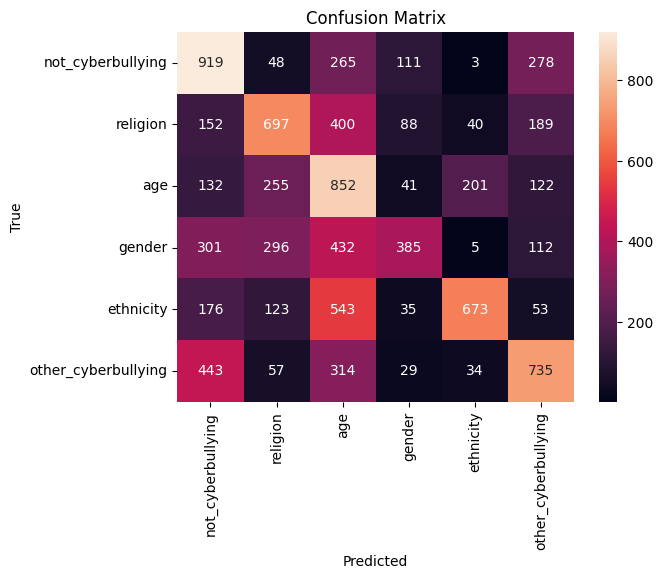



--------------------- Gradient Boosting ---------------------
Accuracy: 0.7425306635915715
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.70      0.65      1624
           1       0.68      0.80      0.74      1566
           2       0.89      0.86      0.87      1603
           3       0.78      0.70      0.74      1531
           4       0.96      0.74      0.84      1603
           5       0.64      0.65      0.64      1612

    accuracy                           0.74      9539
   macro avg       0.76      0.74      0.75      9539
weighted avg       0.76      0.74      0.75      9539



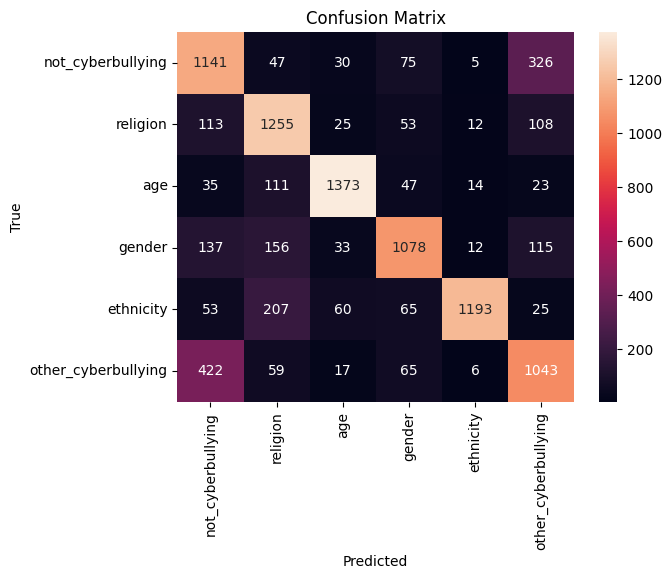

In [16]:
X_train_flat = X_train_padded.reshape(X_train_padded.shape[0], -1)
X_test_flat  = X_test_padded.reshape(X_test_padded.shape[0], -1)

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

for name, classifier in classifiers.items():
    classifier.fit(X_train_flat, y_train)
    y_pred = classifier.predict(X_test_flat)
    
    accuracy    = accuracy_score(y_test, y_pred)
    report      = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"--------------------- {name} ---------------------")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=None, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print("\n")

In [17]:
# Build the LSTM model
embedding_dim = 100
num_classes   = 6

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=100),
    Dense(units=num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/10
1193/1193 [==============================] - 49s 36ms/step - loss: 0.6176 - accuracy: 0.7272 - val_loss: 0.4736 - val_accuracy: 0.8111
Epoch 2/10
1193/1193 [==============================] - 10s 9ms/step - loss: 0.3480 - accuracy: 0.8631 - val_loss: 0.4391 - val_accuracy: 0.8294
Epoch 3/10
1193/1193 [==============================] - 10s 8ms/step - loss: 0.2457 - accuracy: 0.9111 - val_loss: 0.4673 - val_accuracy: 0.8259
Epoch 4/10
1193/1193 [==============================] - 9s 7ms/step - loss: 0.1824 - accuracy: 0.9335 - val_loss: 0.5130 - val_accuracy: 0.8190
Epoch 5/10
1193/1193 [==============================] - 7s 6ms/step - loss: 0.1428 - accuracy: 0.9440 - val_loss: 0.5770 - val_accuracy: 0.8178
Epoch 6/10
1193/1193 [==============================] - 8s 7ms/step - loss: 0.1178 - accuracy: 0.9504 - val_loss: 0.6370 - val_accuracy: 0.8128
Epoch 7/10
1193/1193 [==============================] - 8s 7ms/step - loss: 0.0999 - accuracy: 0.9542 - val_loss: 0.7505 - val_accur

In [19]:
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=class_labels))

299/299 [==============================] - 1s 2ms/step
                     precision    recall  f1-score   support

  not_cyberbullying       0.57      0.45      0.50      1624
           religion       0.93      0.93      0.93      1566
                age       0.93      0.98      0.95      1603
             gender       0.84      0.86      0.85      1531
          ethnicity       0.99      0.95      0.97      1603
other_cyberbullying       0.56      0.66      0.61      1612

           accuracy                           0.80      9539
          macro avg       0.80      0.80      0.80      9539
       weighted avg       0.80      0.80      0.80      9539



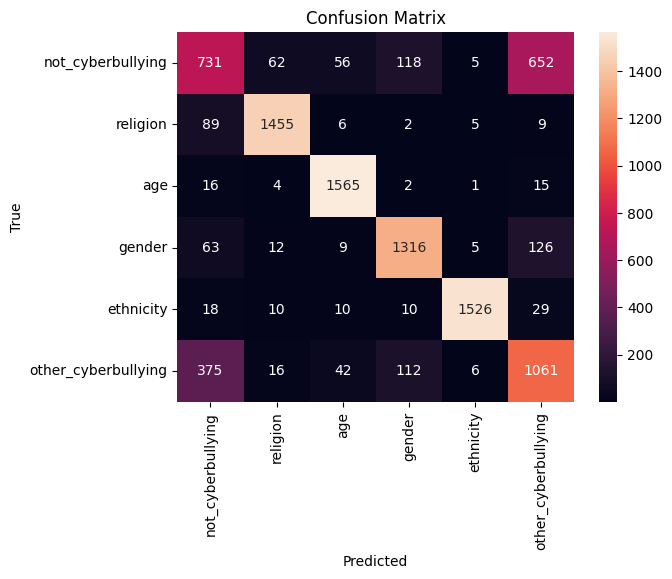

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap=None, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()